# Confidence Intervals

Now that we have gone over the fundamentals of linear regression, we will take a lot at the uncertainty in our different estimates.

Before we get started, let's import the packages we will need.

In [1]:
# load packages
import numpy as np
import pickle as pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=16,weight='bold') #set default font size and weight for plots

And, let's load in our ENSO and California precipitation data again.

In [2]:
# ENSO Data:
# unpickle NINO34 (units of degC)
with open('NINO34_NDJF.pickle','rb') as fp: #.pickle files are a python file type
    nino34 = pickle.load(fp,encoding='latin1')[0]

In [3]:
#  Precipitation Data:
#  unpickle CA_PRECIP_DJFM (units of mm/day)
with open('CA_PRECIP_DJFM.pickle','rb') as fp: #.pickle files are a python file type
    precip_djfm = pickle.load(fp,encoding='latin1')

Let's also read in the data that identifies the La Niña and El Niño events.

In [4]:
# unpickle data indicating strong El Niño/La Niña years
with open('ENSO_NDJF_years_rev.pickle','rb') as fp:   #another .pickle file
    elnino_yrs,lanina_yrs = pickle.load(fp,encoding='latin1')

# create groups of strong El Niño/La Niña years
ElNinoyrs = nino34[np.squeeze(elnino_yrs)]
LaNinayrs = nino34[np.squeeze(lanina_yrs)]

ElNinoP = precip_djfm[np.squeeze(elnino_yrs)]
LaNinaP = precip_djfm[np.squeeze(lanina_yrs)]

## Confidence Intervals on the Slope and Intercept

Before we discuss the second way to calculate the best-fit line using python, let's talk about confidence intervals. Often we want to quantify the 95% confidence intervals on our estimate of the slope and y-intercept. To do this, we need an estimate of the **standard error of the slope**, $s_{a_1}$, and the **standard error of the y-intercept**, $s_{a_0}$. We are not going to get into the derivation of these quantities, but if you're interested, you can check it out [here](https://www.youtube.com/watch?v=rODUBTRUV0U).

Let's start by defining the **standard error of the regression**, $s_{y/x}$. This is analogous to the standard error of the sample mean that we have seen previously - it is simply the square-root of the sum of squared errors ($Q$) divided by the square-root of $N$ - 2,
 
$$
s_{y/x} = \sqrt{\frac{\sum\limits_{i=1}^N(\hat{y_i}(t) - y_i(t))^2}{N-2}}
$$

Notice that we are dividing by $N$ - 2 in this case. This is because we have used up two degrees of freedom to estimate the slope and the y-intercept.

The standard error of the slope is then defined as,

$$
s_{a_1} = \frac{s_{y/x}}{\sqrt{\sum\limits_{i=1}^N(x_i(t) - \overline{x})^2}}
$$

Looking at this equation, you can see intuitively that it is looks like the standard error of the regression divided by the variance in $x$ - sort of like a slope of errors or variances. 

With this definition of the standard error of the slope, we can calculate confidence intervals in the usual way. For example,

$$
a_1 - t_{\alpha/2}s_{a_1} \leq b_1 \leq a_1 + t_{\alpha/2}s_{a_1}
$$

where $b_1$ is the true value for the slope and $t_{\alpha/2}$ is the critical $t$-value with $\nu$ = $N$ - 2.

We can also compute the standard error of the y-intercept as follows,

$$
s_{a_0} = s_{y/x}\sqrt{\frac{\sum\limits_{i=1}^Nx_i(t)^2}{N\sum\limits_{i=1}^Nx_i(t)^{\prime2}}}
$$



Again, we can now calculate the confidence intervals in the usual way.

$$
a_0 - t_{\alpha/2}s_{a_0} \leq b_0 \leq a_0 + t_{\alpha/2}s_{a_0}
$$

Now, that we have taken a look at the standard errors and confidence intervals, we can try out the second python function for linear regression. This function is part of the `scipy.stats` package and there are multiple outputs. In this section, we will just worry about the slope, intercept and standard error outputs (we will discuss the other outputs in the next section).

Let's try it out. 

In [5]:
# alternate way to calculate the best fit
slope, intercept, r_value, p_value, s_a1 = st.linregress(nino34,precip_djfm)

# calculate fit
y_hat = intercept + nino34*slope

By default, the above function outputs the standard error of the slope, but we can use this to compute the standard error of the y-intercept.

First, let's compute the 95% confidence intervals on the slope. To do this, we need to find our critical $t$-value.

In [6]:
# find t_crit for our 95% confidence intervals on our slope
t_crit = st.t.ppf(0.975,len(nino34)-2) # two-sided, v = N - 2

Now, we multiply our critical $t$-value by the standard error of the slope.

In [7]:
# calculate the 95% confidence interval on the slope
confidence_interval_slope = t_crit*s_a1
print("The true value of the slope is then", np.round(slope,2), "+/-", np.round(confidence_interval_slope,2))

The true value of the slope is then 0.44 +/- 0.05


To find the standard error of the intercept, we can first find $s_{y/x}$.

In [8]:
# calculate the standard error of the regression, s_y/x
s_yx = s_a1*np.sqrt(np.var(nino34)*(len(nino34)-1))
print(s_yx)

0.8350837859208119


Now, we can compute $s_{a_0}$ and the 95% confidence intervals.

In [9]:
# calculate the standard error of the intercept, s_a0
s_a0 = s_yx*np.sqrt(np.sum(nino34**2)/((len(nino34)-1)*len(nino34)*np.var(nino34)))

# calculate the 95% confidence interval on the intercept
confidence_interval_yint = t_crit*s_a0
print("The true value of the intercept is then", np.round(intercept,2), "+/-", np.round(confidence_interval_yint,2))

The true value of the intercept is then 2.5 +/- 0.05


## Confidence Band on the Estimate

We can also calculate the *confidence band* for $\hat{y(t)}$. To do this, we use the standard error of the fit, $s_{\hat{y}}$. Again, we are not going to worry about the derivation of this formula, but we want to have a sense of why it looks the way it does.

$$
s_{\hat{y}} = s_{y/x}\sqrt{\frac{1}{N} + \frac{(x_i(t) - \overline{x})^2}{\sum\limits_{i=1}^Nx_i(t)^{\prime2}}}
$$

Now, we can now calculate the confidence band in the usual way.

$$
\hat{y(t)} - t_{\alpha/2}s_{\hat{y}} \leq y(t) \leq \hat{y(t)} + t_{\alpha/2}s_{\hat{y}}
$$

Taking a look at the formula, how does $s_{\hat{y}}$ vary as $x(t)$ gets closer or farther away from the mean, $\overline{x}$? $s_{\hat{y}}$ should get smaller the closer we are to $\overline{x}$. This means that we are more confident in our estimate, $\hat{y(t)}$, near the centre of the data, $\overline{x}$, than we are at the edges. 


Let's add the 95\% confidence band to our plot. We will use the command `plt.fill_between()` to shade in the confidence band.

In [10]:
# calculate the standard error of the fit, s_yhat
s_yhat = s_yx * (np.sqrt( (1/len(nino34)) + ((nino34 - np.mean(nino34))**2)/np.sum((nino34-np.mean(nino34))**2)))

# calculate the 95% confidence band
confidence_band = t_crit*s_yhat

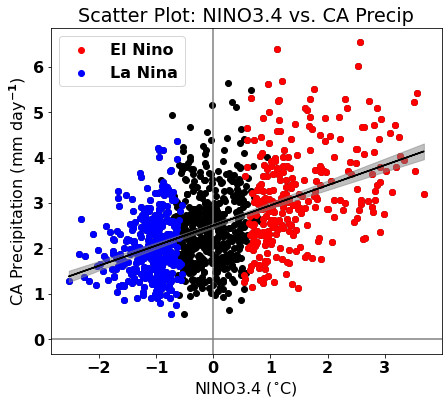

In [11]:
# replot the original scatter plots
plt.figure(figsize=(7,6))
plt.axhline(0,color='gray')  #add zero lines for reference
plt.axvline(0,color='gray')  #add zero lines for reference
plt.scatter(nino34,precip_djfm,color='k')
plt.scatter(ElNinoyrs,ElNinoP,color='r',label='El Nino')
plt.scatter(LaNinayrs,LaNinaP,color='b',label='La Nina')

# add linear fit on top
plt.plot(nino34,y_hat,'k')

# add confidence band (we need to sort the data in ascending order to get the plot to look correct)
plt.fill_between(np.sort(nino34),np.sort(y_hat - confidence_band), np.sort(y_hat + confidence_band),color = 'gray',alpha=0.5)

# labels, legends, etc.
plt.xlabel('NINO3.4 ($^{\circ}$C)')
plt.ylabel('CA Precipitation (mm day$^{-1}$)')
plt.title('Scatter Plot: NINO3.4 vs. CA Precip')
plt.legend(loc='upper left')